In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import datetime
import seaborn as sns
from scipy import stats

In [2]:
def scale(dataset,col_name, output_array=False):
    """Standard Z score scaler"""
    array = dataset[col_name].to_numpy()
    mean = np.mean(array)
    std = np.std(array)
    scaled = (array-mean)/std
    if output_array:
        return scaled
    else:
        return scaled, mean, std 

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, variable_num = 0,  dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[variable_num].shift(-i))
        if i == 0:
            names.append('var1(t)')
        else:
            names.append('var%d(t+%d)' % (1, i))
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg, names

In [4]:
def random_date(array, lockdown=False):
    """ Choose a random date within lockdown or out of lockdown."""
    if lockdown:
        return np.random.choice(array[(array > pd.to_datetime('2020-03-24')) & (array < pd.to_datetime('2020-06-23')) ])
    else:
        #ensure a years worth of hourly data is available for training.
        array = pd.to_datetime(array[(24*365):])
        
        # 2020-01-01 ensures only non-lockdown entries will be considered
        return np.random.choice(array[array < pd.to_datetime('2020-01-01')])

In [5]:
def split_by_date( dataset , reframed_data, date, days_prior=60):
    
    """ Split reframed data by specific date, days refers to the number 
    of days after the specified date the test set will contain.
    days prior refers to the number of days used to train the model """
    
    #get values from reframed data
    values = reframed_data.values
    
    #convert string into datetime
    date = pd.to_datetime(date)
    
    #create new dataframe
    df = dataset.reset_index().rename(columns = {'index':'date'})
    
    #ensure dates are in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    #find index for date
    date1_index = df.index[df['date'] == date1 ][0]
    
    #set train values to be all data upto given date 
    train = values[ date1_index - n_hours - (24*days_prior) : date1_index - n_hours, :]
    
    #remove training dataset so that tests can be done on the remaining datapoints 
    leftover_before = values[ : date1_index - n_hours - (24 * days_prior) , :]
    leftover_after = values[ date1_index - n_hours : , :]

    #get index of second date is 1 month into future
    date2_index = date1_index + (30 * 24)

    #test set two months after specified date
    test = values[ ( date1_index - n_hours ) : (date2_index - n_hours)  + 1 , :]
    
    #get specific dates for test period
    dates = df.date.to_numpy()
    specific_dates = dates[ date1_index  : date2_index+1  ]
    
    if leftover_before.shape[0] > leftover_after.shape[0]:
        
        return train , test, specific_dates, leftover_before
    
    else:
        return train , test, specific_dates, leftover_after

In [6]:
def reshape(data, n_seq, n_steps, n_features):
    """ Reshape puts data in apprpriate format for LSTM_CNN usage
    [samples, n_seqs, timesteps, features] """
    n_obs = n_hours * n_features

    #split according to lag columns and output
    data_X, data_y = data[:, :n_obs], data[:, n_obs:]
         
    # reshape input to be 3D [samples, timesteps, features]
    data_X_r = data_X.reshape((data_X.shape[0], n_seq , n_steps, n_features))

    return data_X, data_y , data_X_r 

In [7]:
def inverse_scale(array,mean,std):
    """ Inversion of Standard scaler """
    inverse = (array*std) + mean 
    return inverse

In [8]:
def CNN_LSTM_model(cells, filter_no, filter_size, dropout, layers):
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
    if layers == 1:
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(dropout)))
    
    if layers == 2:
        filter_no = int ( filter_no / 2 )
        filter_size += 2
        dropout += 0.1
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Dropout(dropout)))
    
    if layers == 3:
        filter_no = int ( filter_no / 2 )
        filter_size += 2
        dropout += 0.1
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Dropout(dropout)))
        
        filter_no = int ( filter_no / 2 )
        filter_size += 2
        dropout += 0.1
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
        model.add(TimeDistributed(Dropout(dropout)))
    
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(cells, activation = 'relu',input_shape=(train_X_r.shape[1], train_X_r.shape[2])))
    model.add(Dense(n_hours, activation = 'relu'))
    model.add(Dense(n_hours_out))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [9]:
def hour_predictor(test_r, index , timesteps):
    """ Rolling one hour prediction: uses previous 
    1 hour predictions to predict 1 hour ahead """
    
    #starting sequence used to get first prediction. 
    start = test_r[index].reshape(1,n_hours,n_features)
    
    #empty array to store results 
    results = []
    
    #get first prediction
    result = model.predict(start)[0][0]
    
    #record it 
    results.append(result)
    
    for i in range (1,timesteps):

        #shift window one time step
        start = np.delete(start[0],0,0)
        next_ts = test_r[index+i][2]
        start = np.append(start,next_ts).reshape(1,n_hours,n_features)

        #add prediction
        start[0][n_hours-1][0] = result

        #make new prediction
        result = model.predict(start)[0][0]

        results.append(result)
        
    return np.array(results)

In [10]:
# paramter ranges
sites = ['MCC','sharston']
FILTERS = [32]
FILTER_SIZE = [2]
HOURS_BEFORE = [24]
BATCH_SIZE = [128]
N_SEQ = [3]
CELLS = [24]
DROPOUT= [0]
EPOCHS = [100]
TRAIN_SIZE = [365]
LAYERS = [3]
VARIABLES = [['NO2'],['NO2','Volume'],['NO2','ws'],
             ['NO2','ws' ,'temp','wd_1', 'wd_2', 'wd_3', 'wd_4'],
             ['NO2','Volume' ,'ws' ,'temp','wd_1', 'wd_2', 'wd_3', 'wd_4'],
             ['NO2', 'ws' ,'temp','wd_1', 'wd_2', 'wd_3', 'wd_4', 'Volume','Mon', 'Tue', 'Wed',
             'Thu', 'Fri', 'Sat', 'Sun']]
TIMESTEPS = 1 # for rolling prediction
periods = ['2020-03-23','2020-01-23']

# LOCKDOWN = False
# rdm_date = False
plot_days = 30

results = []

print ('runs:', len(HOURS_BEFORE)*len(BATCH_SIZE)
      *len(CELLS)* len(DROPOUT) * len(EPOCHS) * len(TRAIN_SIZE)
      * len(VARIABLES)* len(N_SEQ) * len(LAYERS) * len(sites) *len(periods) * 5)


runs: 120


MCC, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2'], layers:3  
1, 0, RMSE:7.511168956756592, MAPE:0.3190537095069885, r2: 0.7953851250593547, corr:0.9016271369945443,(6.346038061619636e-264) 
2, 1, RMSE:7.558247089385986, MAPE:0.35474950075149536, r2: 0.7928121238444299, corr:0.9019572455037592,(2.016713108928894e-264) 
3, 2, RMSE:7.563549995422363, MAPE:0.36926138401031494, r2: 0.7925213065941079, corr:0.903353735359168,(1.50913584245682e-266) 


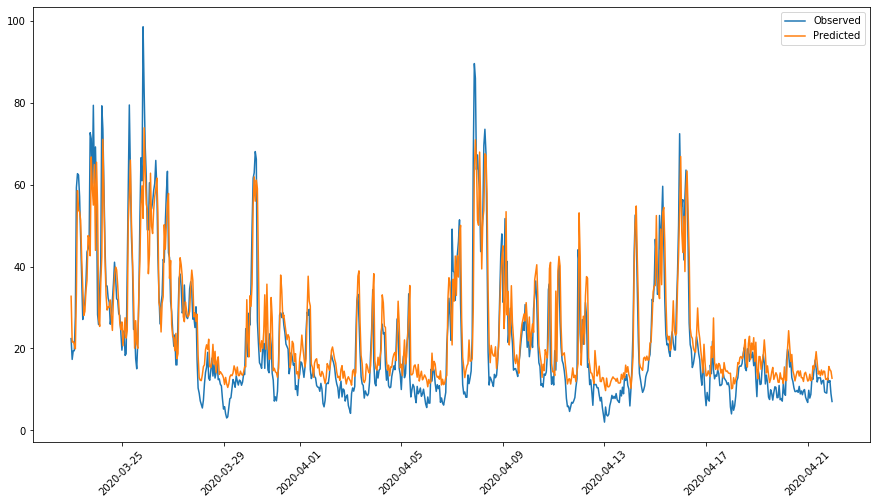

4, 3, RMSE:7.5702385902404785, MAPE:0.3686477243900299, r2: 0.7921542079080519, corr:0.9027770565427219,(1.1495579488181291e-265) 
5, 4, RMSE:8.24746322631836, MAPE:0.44840696454048157, r2: 0.753303520047419, corr:0.8991596432170383,(2.9434190479498427e-260) 
MCC, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'Volume'], layers:3  
6, 0, RMSE:8.40967082977295, MAPE:0.4549444019794464, r2: 0.7435043208983605, corr:0.8985700475404599,(2.1421881288820614e-259) 
7, 1, RMSE:9.30766773223877, MAPE:0.5691084861755371, r2: 0.6858016922705841, corr:0.891356797328239,(2.9254864005137156e-249) 
8, 2, RMSE:10.115478515625, MAPE:0.565511167049408, r2: 0.6288965822417105, corr:0.8913837473358054,(2.6895249273806357e-249) 


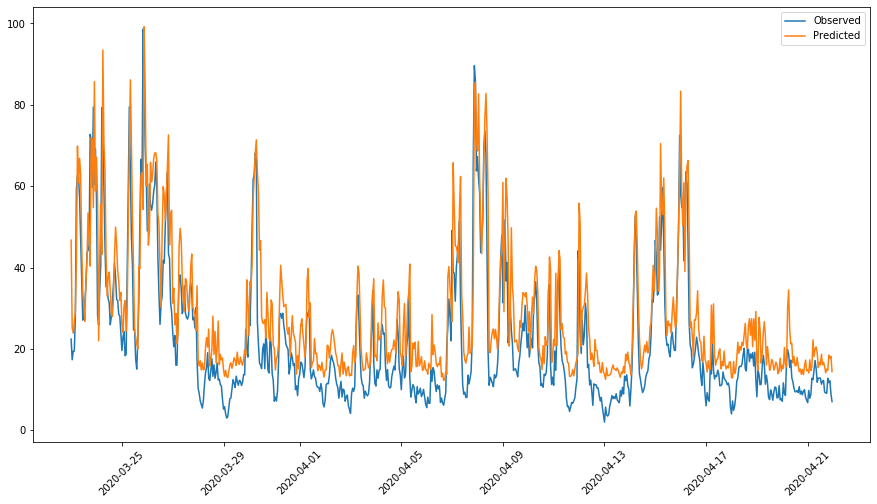

9, 3, RMSE:8.974916458129883, MAPE:0.5286620855331421, r2: 0.7078654104920539, corr:0.8988077345917577,(9.638120962345075e-260) 
10, 4, RMSE:8.792131423950195, MAPE:0.49878010153770447, r2: 0.7196435697354129, corr:0.8935127137545744,(3.263198342403523e-252) 
MCC, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws'], layers:3  
11, 0, RMSE:8.610164642333984, MAPE:0.5260775089263916, r2: 0.7311283444214358, corr:0.9064601338606294,(2.143596450652422e-271) 
12, 1, RMSE:8.309385299682617, MAPE:0.4873584508895874, r2: 0.7495852487136205, corr:0.9061991073893543,(5.558609789042112e-271) 
13, 2, RMSE:7.75474739074707, MAPE:0.40052223205566406, r2: 0.7818991170615878, corr:0.9039298956265174,(1.9595357607675537e-267) 


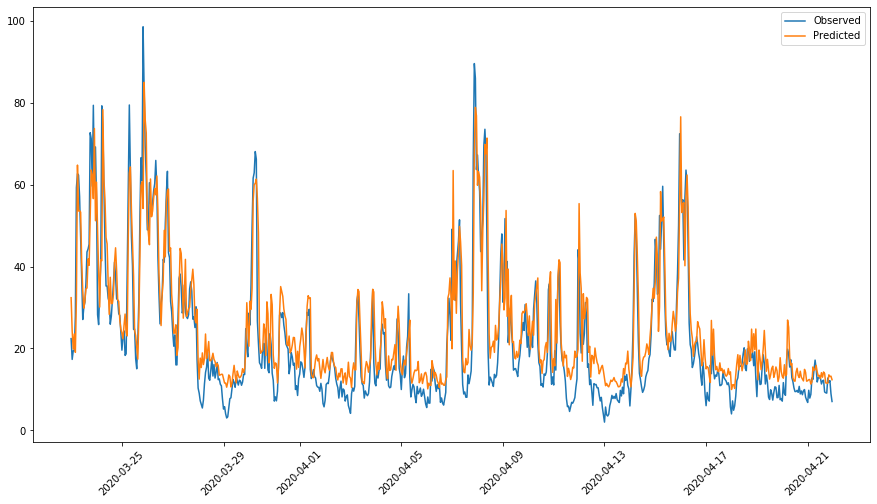

14, 3, RMSE:8.318548202514648, MAPE:0.48063966631889343, r2: 0.7490326652375534, corr:0.9028386157101222,(9.261133516026555e-266) 
15, 4, RMSE:8.29565715789795, MAPE:0.47568169236183167, r2: 0.750411994516275, corr:0.9046129845835185,(1.7129336721357964e-268) 
MCC, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4'], layers:3  
16, 0, RMSE:8.751708984375, MAPE:0.40258678793907166, r2: 0.722215607287112, corr:0.8808273497768981,(1.1022690622467313e-235) 
17, 1, RMSE:10.348130226135254, MAPE:0.7226494550704956, r2: 0.611629823524362, corr:0.8855542483615627,(1.2970574735278467e-241) 
18, 2, RMSE:8.914135932922363, MAPE:0.5024645328521729, r2: 0.7118088489361594, corr:0.8862661076566126,(1.5753630014580325e-242) 


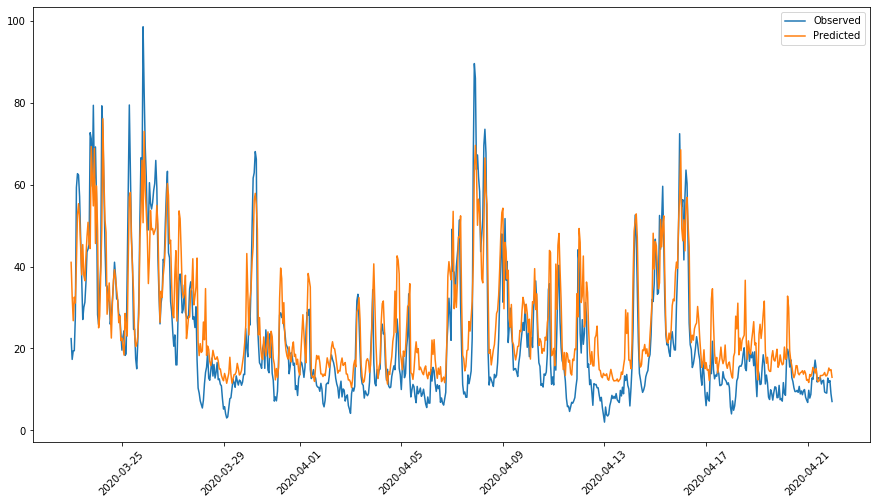

19, 3, RMSE:9.170802116394043, MAPE:0.5636308193206787, r2: 0.6949740503788411, corr:0.886629714661287,(5.337688881296309e-243) 
20, 4, RMSE:9.72062873840332, MAPE:0.6124582290649414, r2: 0.6573025646678707, corr:0.8816051102158563,(1.213853396464758e-236) 
MCC, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'Volume', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4'], layers:3  
21, 0, RMSE:9.412786483764648, MAPE:0.4525492787361145, r2: 0.6786646216445684, corr:0.8457670570769744,(2.4333825120643253e-198) 
22, 1, RMSE:9.520500183105469, MAPE:0.574064314365387, r2: 0.6712682048920213, corr:0.8714050875034234,(1.3908859925617208e-224) 
23, 2, RMSE:9.073638916015625, MAPE:0.3381583094596863, r2: 0.7014032457471752, corr:0.8516574275308088,(6.324697682762e-204) 


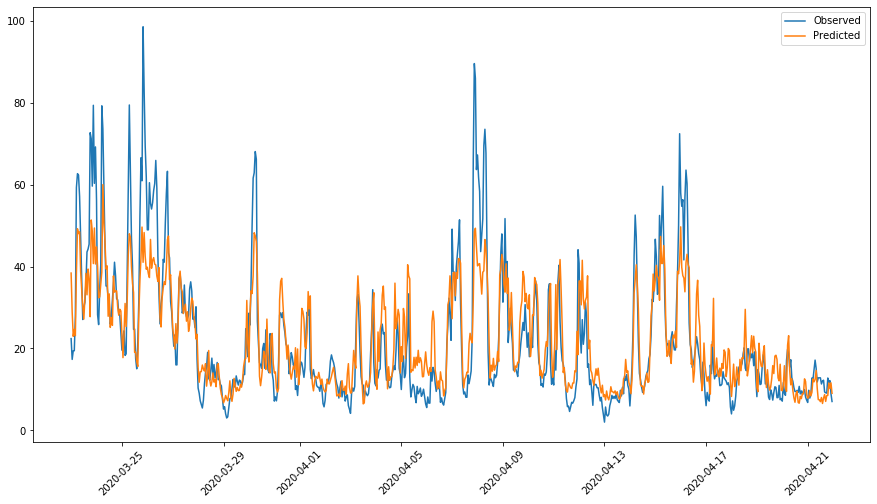

24, 3, RMSE:11.879931449890137, MAPE:0.749531090259552, r2: 0.48814140596519673, corr:0.8748931394571553,(1.376920611845836e-228) 
25, 4, RMSE:10.238690376281738, MAPE:0.6178939342498779, r2: 0.6198010385887192, corr:0.8787663988911958,(3.540871561234489e-233) 
MCC, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'Volume', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], layers:3  
26, 0, RMSE:10.342191696166992, MAPE:0.5928424596786499, r2: 0.6120754713516741, corr:0.8622495239660862,(1.3187773249334018e-214) 
27, 1, RMSE:11.354126930236816, MAPE:0.7457635402679443, r2: 0.5324483393226193, corr:0.8747306246605956,(2.1288082415470477e-228) 
28, 2, RMSE:10.861159324645996, MAPE:0.636382520198822, r2: 0.57216678494741, corr:0.8720382784943221,(2.6615198753407192e-225) 


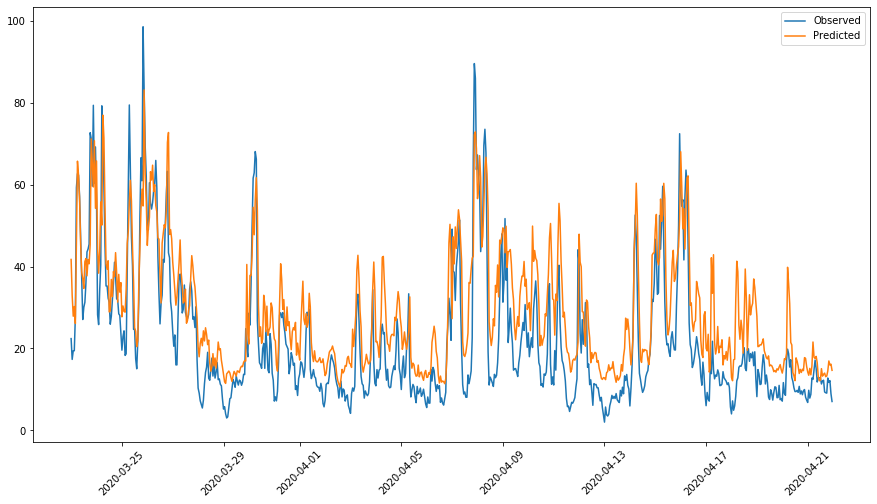

29, 3, RMSE:9.930985450744629, MAPE:0.5156844854354858, r2: 0.6423099466985329, corr:0.8424550950804612,(2.658826296229659e-195) 
30, 4, RMSE:12.94258975982666, MAPE:0.8148181438446045, r2: 0.3924744661561257, corr:0.8759492297149503,(7.99372906580211e-230) 
MCC, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2'], layers:3  
31, 0, RMSE:7.555161952972412, MAPE:0.21184870600700378, r2: 0.8373476254018555, corr:0.921801956577883,(4.03510405654712e-298) 
32, 1, RMSE:7.247461795806885, MAPE:0.20000363886356354, r2: 0.8503265839898899, corr:0.9265996219859952,(1.2808688917296486e-307) 
33, 2, RMSE:7.771157264709473, MAPE:0.21906062960624695, r2: 0.8279145338702543, corr:0.9200205269452996,(9.522771385289309e-295) 


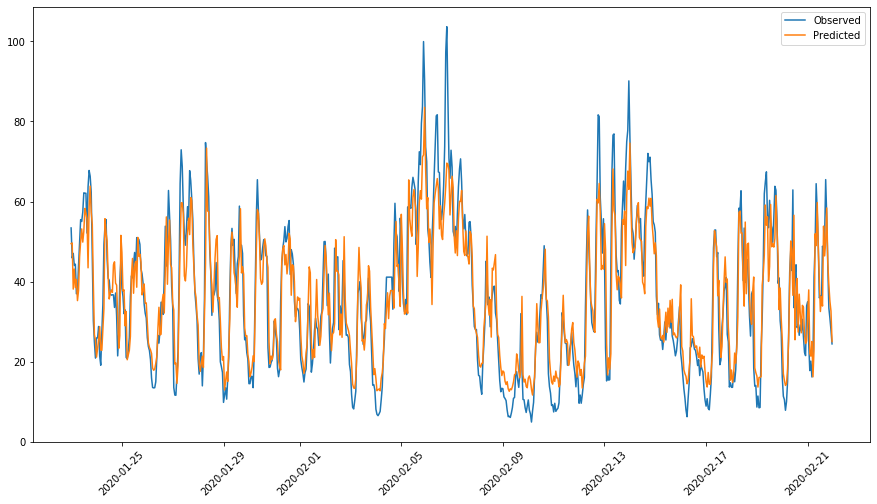

34, 3, RMSE:7.530388832092285, MAPE:0.20193377137184143, r2: 0.8384125650866292, corr:0.9214833777209018,(1.640202586075793e-297) 
35, 4, RMSE:7.834807395935059, MAPE:0.22999779880046844, r2: 0.8250840222731739, corr:0.92519753834389,(8.886298703661607e-305) 
MCC, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'Volume'], layers:3  
36, 0, RMSE:7.95286226272583, MAPE:0.2037830501794815, r2: 0.8197730679647282, corr:0.9200900505380004,(7.0567885155292184e-295) 
37, 1, RMSE:8.208724021911621, MAPE:0.22575221955776215, r2: 0.807989891366746, corr:0.9217380396251932,(5.348787694169218e-298) 
38, 2, RMSE:7.658371448516846, MAPE:0.20781256258487701, r2: 0.8328733854669523, corr:0.9202809932601194,(3.094072210645678e-295) 


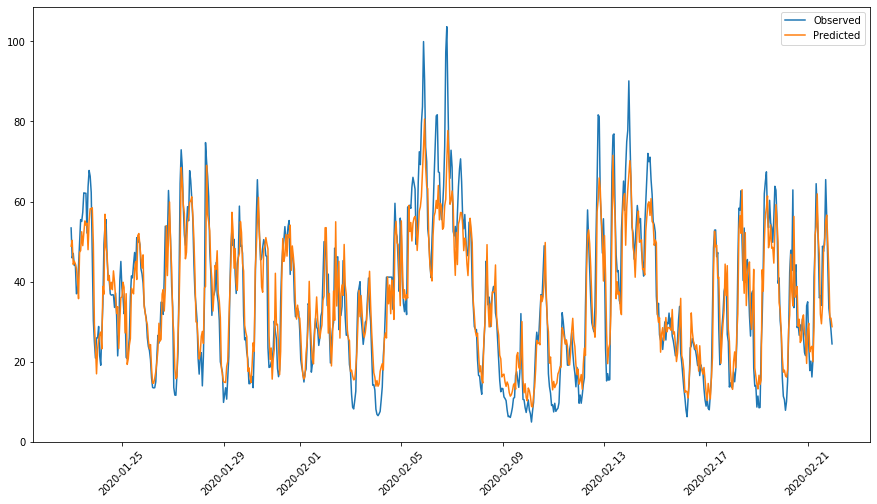

39, 3, RMSE:8.122666358947754, MAPE:0.2309764176607132, r2: 0.8119947452121798, corr:0.9232248732010979,(7.138499653643372e-301) 
40, 4, RMSE:8.13066291809082, MAPE:0.2354351133108139, r2: 0.8116243790066282, corr:0.9142931450787267,(2.0575481612711923e-284) 
MCC, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws'], layers:3  
41, 0, RMSE:8.422377586364746, MAPE:0.20225116610527039, r2: 0.7978646659229555, corr:0.909349751367746,(4.645755158625913e-276) 
42, 1, RMSE:8.403380393981934, MAPE:0.2164069563150406, r2: 0.7987755035840807, corr:0.9077456011494751,(1.8849246470027405e-273) 
43, 2, RMSE:8.051782608032227, MAPE:0.22543242573738098, r2: 0.8152617289895321, corr:0.909936228464634,(5.02739235809314e-277) 


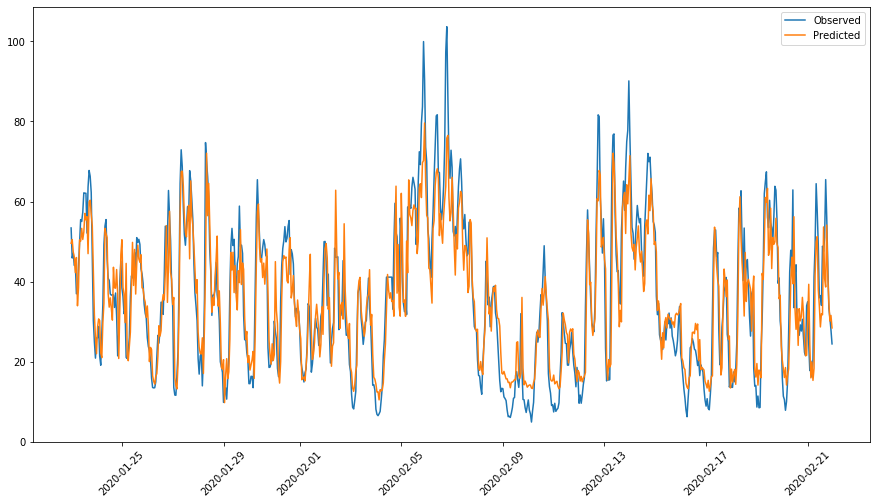

44, 3, RMSE:8.273691177368164, MAPE:0.210391104221344, r2: 0.8049385397943869, corr:0.9115709979116237,(9.422704602325242e-280) 
45, 4, RMSE:8.386067390441895, MAPE:0.2241748422384262, r2: 0.7996037864297822, corr:0.9109636076601186,(9.853255275139402e-279) 
MCC, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4'], layers:3  
46, 0, RMSE:8.832661628723145, MAPE:0.20113873481750488, r2: 0.7776915556390481, corr:0.9093834941842488,(4.089522586931878e-276) 
47, 1, RMSE:9.018512725830078, MAPE:0.2992725670337677, r2: 0.7682377942236044, corr:0.889617322285972,(6.358410788293977e-247) 
48, 2, RMSE:9.736193656921387, MAPE:0.24972529709339142, r2: 0.7298834227409337, corr:0.9058964479973837,(1.6721530379363692e-270) 


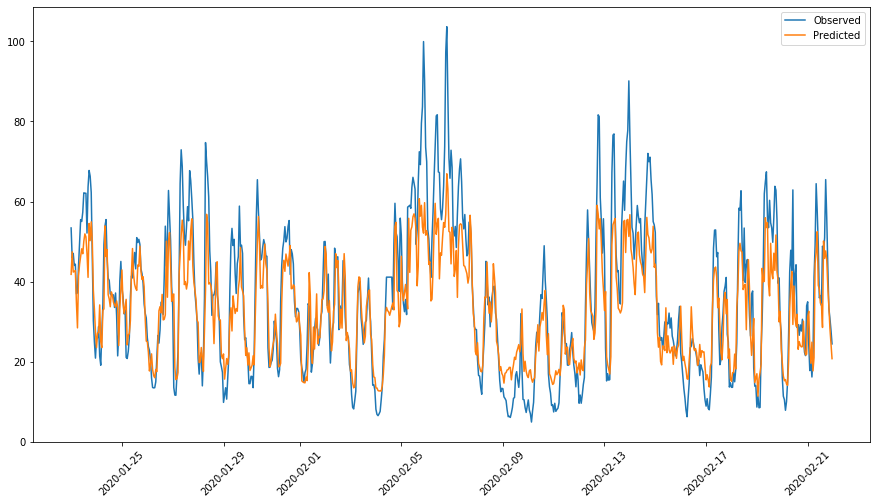

49, 3, RMSE:9.056509017944336, MAPE:0.2050882875919342, r2: 0.7662807835670196, corr:0.9013913152362845,(1.4357571610532235e-263) 
50, 4, RMSE:8.668889999389648, MAPE:0.2422793209552765, r2: 0.7858589872614862, corr:0.8969936753705707,(4.071392144923396e-257) 
MCC, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'Volume', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4'], layers:3  
51, 0, RMSE:9.612367630004883, MAPE:0.20675602555274963, r2: 0.7367105189215425, corr:0.9011656759924925,(3.1297583495566806e-263) 
52, 1, RMSE:7.703273296356201, MAPE:0.20933395624160767, r2: 0.8309078663948645, corr:0.9165948579500084,(1.776655756155023e-288) 
53, 2, RMSE:8.440109252929688, MAPE:0.22624102234840393, r2: 0.7970126747200938, corr:0.9045175646888207,(2.4102864992545314e-268) 


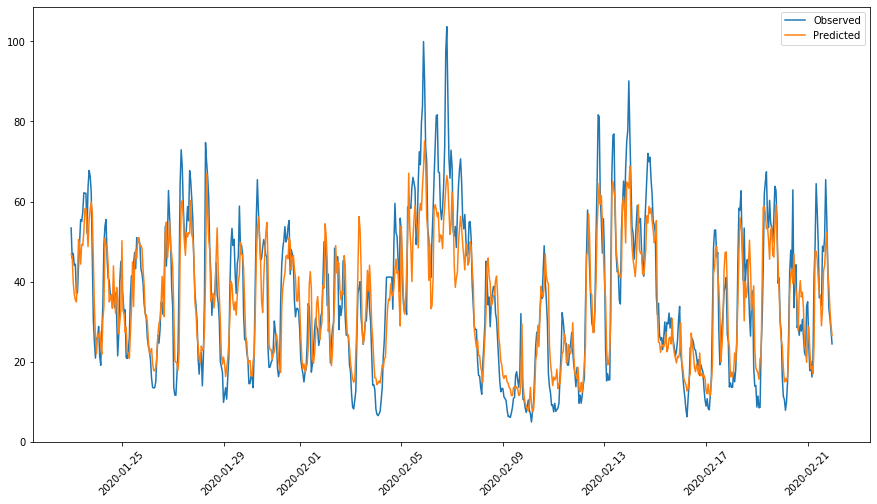

54, 3, RMSE:10.867969512939453, MAPE:0.2222844362258911, r2: 0.6634344939403451, corr:0.887074110546313,(1.414822607088472e-243) 
55, 4, RMSE:8.115253448486328, MAPE:0.21471290290355682, r2: 0.812337711192294, corr:0.9196957727085199,(3.847504141606307e-294) 
MCC, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'Volume', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], layers:3  
56, 0, RMSE:8.91680908203125, MAPE:0.2301846593618393, r2: 0.7734355386388188, corr:0.8922992666400279,(1.524786910613178e-250) 
57, 1, RMSE:10.43609619140625, MAPE:0.2764199674129486, r2: 0.6896520329509735, corr:0.8681618221005196,(5.793565971299608e-221) 
58, 2, RMSE:8.872848510742188, MAPE:0.19754354655742645, r2: 0.7756640157557768, corr:0.8995261389582669,(8.517878106855905e-261) 


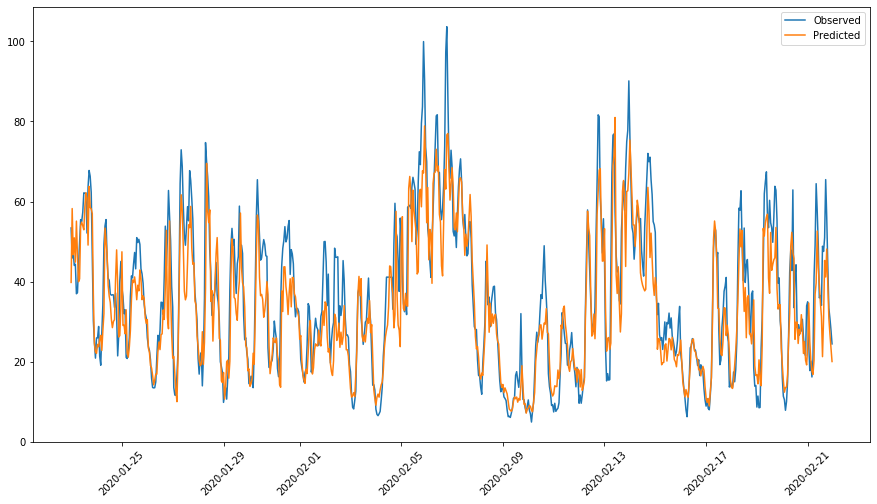

59, 3, RMSE:8.685068130493164, MAPE:0.23857252299785614, r2: 0.7850590321664384, corr:0.8963340265325309,(3.567930859159707e-256) 
60, 4, RMSE:9.39875316619873, MAPE:0.23616734147071838, r2: 0.7482825893018494, corr:0.8763173797886419,(2.945548114619356e-230) 
sharston, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2'], layers:3  
61, 0, RMSE:5.403508186340332, MAPE:0.4760249853134155, r2: 0.6692483493695305, corr:0.8452197330160136,(7.820924895863044e-198) 
62, 1, RMSE:5.252989292144775, MAPE:0.32684484124183655, r2: 0.6874184200306566, corr:0.8313887381617009,(1.2265369306213935e-185) 
63, 2, RMSE:5.451634883880615, MAPE:0.42586255073547363, r2: 0.6633304510927005, corr:0.8392241342625011,(2.098221674164261e-192) 


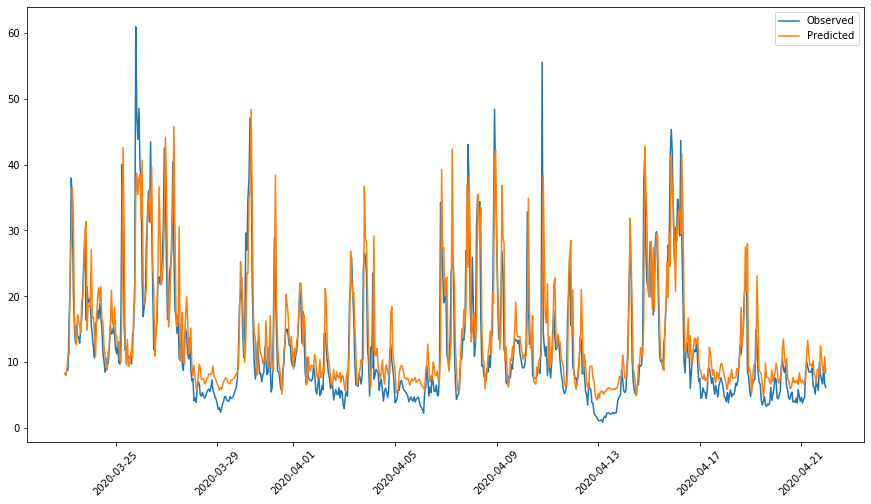

64, 3, RMSE:5.461613178253174, MAPE:0.44461703300476074, r2: 0.6620968372214128, corr:0.8375999481013686,(5.676513283387007e-191) 
65, 4, RMSE:5.091061115264893, MAPE:0.31063970923423767, r2: 0.7063926428494188, corr:0.8428209755811135,(1.2373427143029098e-195) 
sharston, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'Volume'], layers:3  
66, 0, RMSE:5.618602275848389, MAPE:0.5178673267364502, r2: 0.6423922103433966, corr:0.820899968314294,(4.164691593818262e-177) 
67, 1, RMSE:5.981407165527344, MAPE:0.6187916398048401, r2: 0.5947182208935424, corr:0.8131604530231008,(3.662718119549478e-171) 
68, 2, RMSE:6.1168622970581055, MAPE:0.6419002413749695, r2: 0.5761543132115212, corr:0.8107937172791896,(2.1204607884772583e-169) 


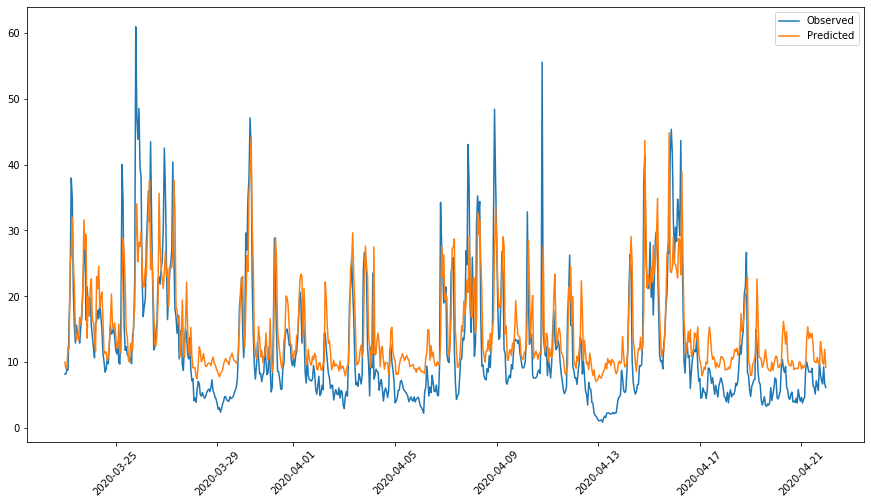

69, 3, RMSE:6.020186901092529, MAPE:0.5995105504989624, r2: 0.5894459366308419, corr:0.8085374051579011,(9.634235699615377e-168) 
70, 4, RMSE:5.58134651184082, MAPE:0.44508883357048035, r2: 0.6471189227028592, corr:0.8145193098483342,(3.470524569697412e-172) 
sharston, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws'], layers:3  
71, 0, RMSE:5.956066608428955, MAPE:0.6070085763931274, r2: 0.5981449368269216, corr:0.820165620165242,(1.5698021261916148e-176) 
72, 1, RMSE:5.891660213470459, MAPE:0.4651515483856201, r2: 0.6067888656987293, corr:0.8158974138218439,(3.117764165024314e-173) 
73, 2, RMSE:6.078085899353027, MAPE:0.610458493232727, r2: 0.581510985294454, corr:0.8246621109815647,(4.219864236477775e-180) 


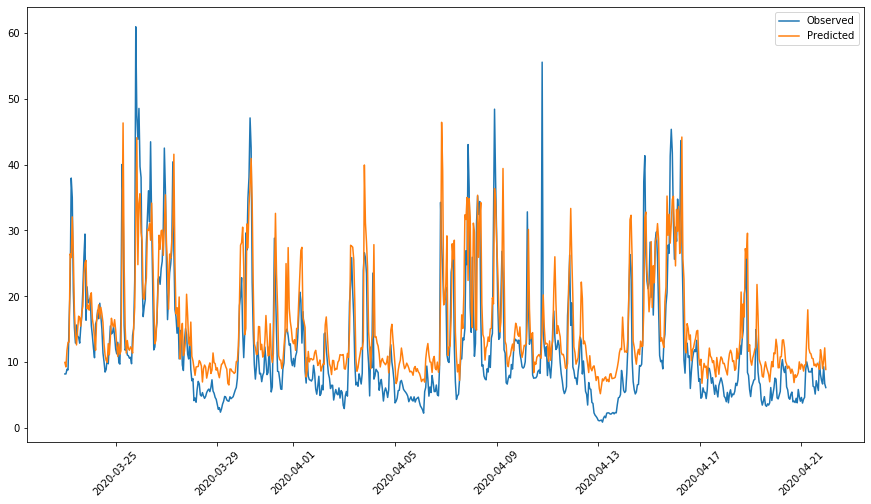

74, 3, RMSE:6.130733966827393, MAPE:0.5830360054969788, r2: 0.5742297316268546, corr:0.8252955067640733,(1.3005539137765156e-180) 
75, 4, RMSE:5.472074508666992, MAPE:0.462863564491272, r2: 0.660801144173241, corr:0.8362435004362998,(8.672479237960251e-190) 
sharston, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4'], layers:3  
76, 0, RMSE:6.32391357421875, MAPE:0.6761385798454285, r2: 0.5469749270097267, corr:0.8203555060003924,(1.1145238902880635e-176) 
77, 1, RMSE:6.8217244148254395, MAPE:0.6824633479118347, r2: 0.47284450809639167, corr:0.7983968944631292,(1.475593304424393e-160) 
78, 2, RMSE:5.744028568267822, MAPE:0.4445783793926239, r2: 0.6262479604034534, corr:0.8222088977332508,(3.853424971685266e-178) 


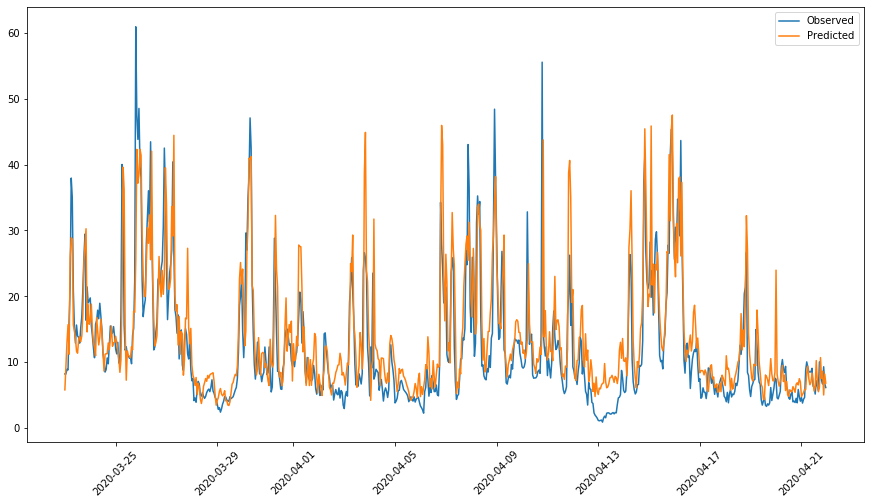

79, 3, RMSE:6.053032875061035, MAPE:0.563578724861145, r2: 0.5849537935665807, corr:0.8001739502441334,(8.707360424525268e-162) 
80, 4, RMSE:6.482226371765137, MAPE:0.6734710335731506, r2: 0.5240089581051974, corr:0.7749311897048546,(2.0983326833545464e-145) 
sharston, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'Volume', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4'], layers:3  
81, 0, RMSE:5.598505020141602, MAPE:0.38909438252449036, r2: 0.6449459436855101, corr:0.80722487838762,(8.666078830207353e-167) 
82, 1, RMSE:6.377786159515381, MAPE:0.6437760591506958, r2: 0.5392234645125904, corr:0.7944503114988687,(7.1607099806927586e-158) 
83, 2, RMSE:6.102617263793945, MAPE:0.6237690448760986, r2: 0.5781261381297886, corr:0.8028631018376404,(1.1379605814590121e-163) 


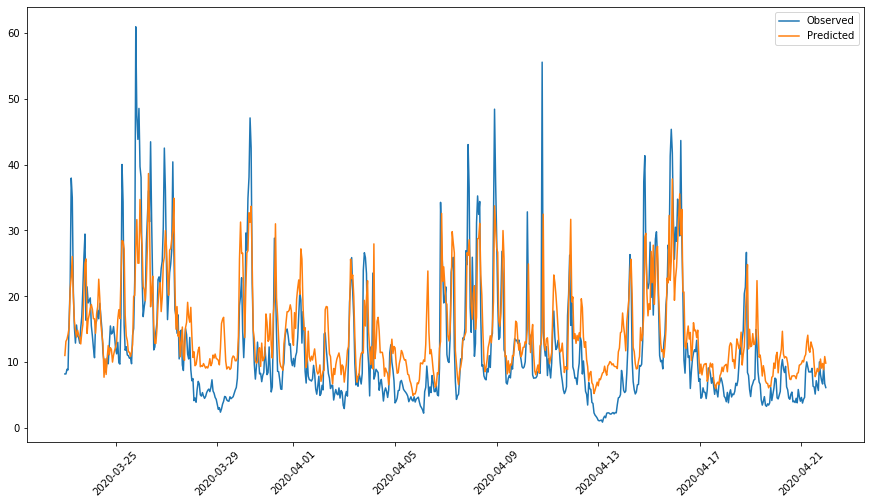

84, 3, RMSE:5.363238334655762, MAPE:0.38007980585098267, r2: 0.6741599010516222, corr:0.8218319700519221,(7.662992356907171e-178) 
85, 4, RMSE:7.454272270202637, MAPE:0.8104134798049927, r2: 0.37055054302498147, corr:0.8054661007423513,(1.6022361297261402e-165) 
sharston, 2020-03-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'Volume', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], layers:3  
86, 0, RMSE:6.21591854095459, MAPE:0.5751911401748657, r2: 0.5623156808766898, corr:0.8100913977326178,(6.993653642232442e-169) 
87, 1, RMSE:6.63792085647583, MAPE:0.714340090751648, r2: 0.5008689933336843, corr:0.7748816736015536,(2.2484930449740378e-145) 
88, 2, RMSE:6.725306510925293, MAPE:0.653281569480896, r2: 0.4876407795107339, corr:0.764048198529173,(5.499922761668894e-139) 


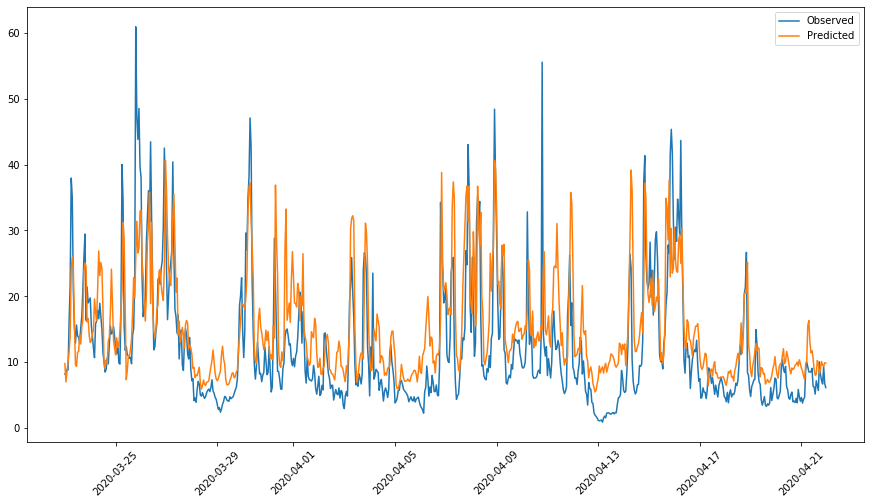

89, 3, RMSE:5.800317764282227, MAPE:0.43840092420578003, r2: 0.6188868754680056, corr:0.793759188489066,(2.0857518868219302e-157) 
90, 4, RMSE:6.491506099700928, MAPE:0.6829855442047119, r2: 0.5226451455241569, corr:0.7818131833749453,(1.1850497319923483e-149) 
sharston, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2'], layers:3  
91, 0, RMSE:7.11749792098999, MAPE:0.42567187547683716, r2: 0.771321983314339, corr:0.8987325089944563,(1.2412664672923797e-259) 
92, 1, RMSE:7.027961254119873, MAPE:0.46825891733169556, r2: 0.7770392516917376, corr:0.894876693542526,(4.098827634020808e-254) 
93, 2, RMSE:7.472568988800049, MAPE:0.4467618465423584, r2: 0.7479366950107207, corr:0.8906224257456935,(2.8689358549231376e-248) 


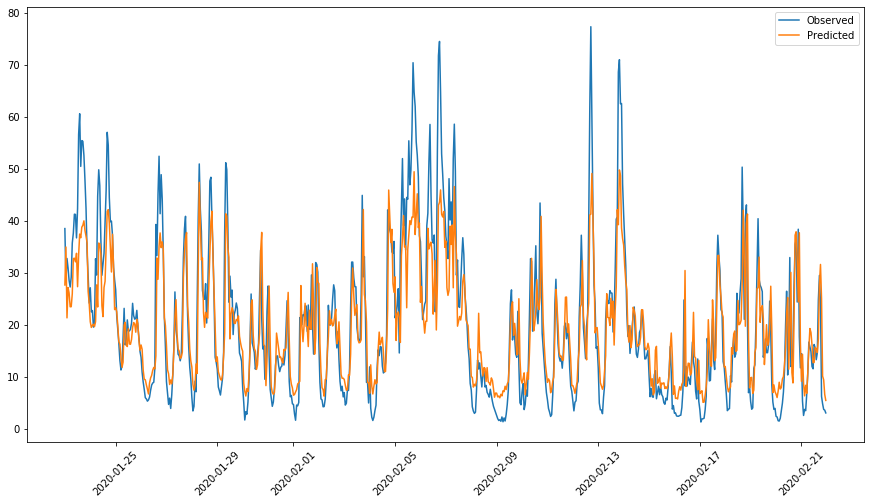

94, 3, RMSE:7.444993019104004, MAPE:0.3856588900089264, r2: 0.7497936428335248, corr:0.8873068936181949,(7.041640022384374e-244) 
95, 4, RMSE:7.456878185272217, MAPE:0.42276719212532043, r2: 0.7489941739313113, corr:0.8899262405471422,(2.4612959858002894e-247) 
sharston, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'Volume'], layers:3  
96, 0, RMSE:7.728273868560791, MAPE:0.4833172559738159, r2: 0.7303907971777047, corr:0.882154223292184,(2.533066811942887e-237) 
97, 1, RMSE:7.450687408447266, MAPE:0.41071420907974243, r2: 0.7494107350909478, corr:0.8825247157799896,(8.761371774245059e-238) 
98, 2, RMSE:7.470457077026367, MAPE:0.4150674641132355, r2: 0.748079178964179, corr:0.8915410330882048,(1.6456225042350987e-249) 


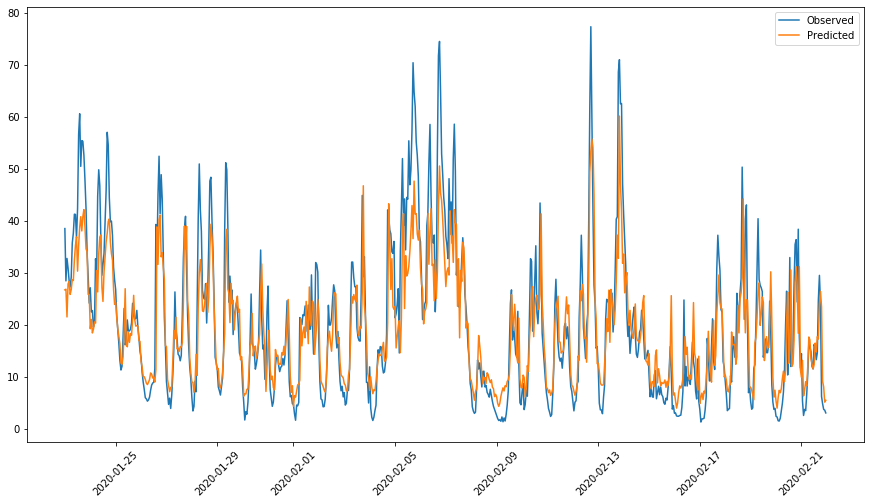

99, 3, RMSE:7.374244213104248, MAPE:0.48337095975875854, r2: 0.7545264348601579, corr:0.8841827826384197,(7.242410245851063e-240) 
100, 4, RMSE:7.5842413902282715, MAPE:0.4538900852203369, r2: 0.7403465911166798, corr:0.8768127517748132,(7.648130357178272e-231) 
sharston, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws'], layers:3  
101, 0, RMSE:7.998896598815918, MAPE:0.4577305316925049, r2: 0.7111782149513655, corr:0.8898979271574794,(2.6853024377463484e-247) 
102, 1, RMSE:7.986252784729004, MAPE:0.4300712049007416, r2: 0.7120905846461223, corr:0.8714113170147652,(1.368499489825619e-224) 
103, 2, RMSE:7.924842357635498, MAPE:0.4995642900466919, r2: 0.7165013295876989, corr:0.8758779698791519,(9.694264364839318e-230) 


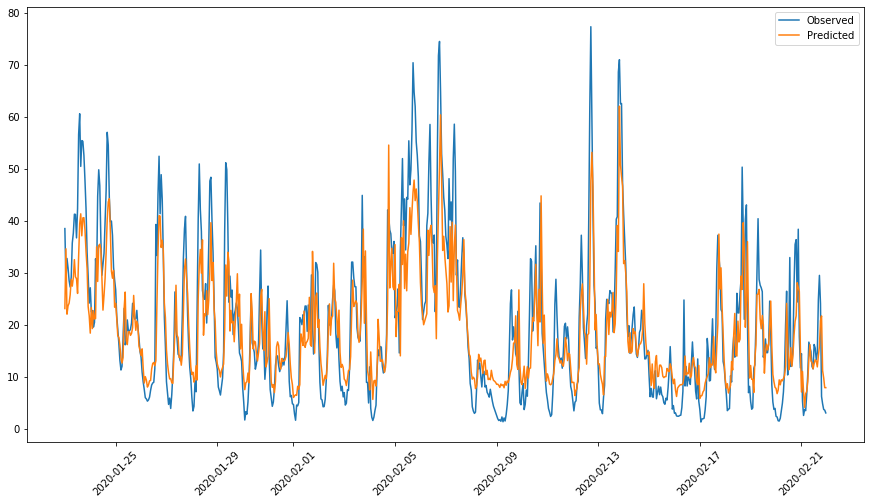

104, 3, RMSE:7.831071853637695, MAPE:0.48155340552330017, r2: 0.7231706483892604, corr:0.8723096612140817,(1.3066381298766559e-225) 
105, 4, RMSE:8.861148834228516, MAPE:0.4882175922393799, r2: 0.6455542233554041, corr:0.8053284536496502,(2.010622244930765e-165) 
sharston, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4'], layers:3  
106, 0, RMSE:7.595652103424072, MAPE:0.4455939829349518, r2: 0.7395646938164657, corr:0.8762285101271053,(3.7493668895130807e-230) 
107, 1, RMSE:8.910367012023926, MAPE:0.5939188599586487, r2: 0.6416058145406008, corr:0.8501448012903872,(1.8120671119955794e-202) 
108, 2, RMSE:8.571039199829102, MAPE:0.49939659237861633, r2: 0.6683831283620225, corr:0.8419176567682066,(8.149264792406695e-195) 


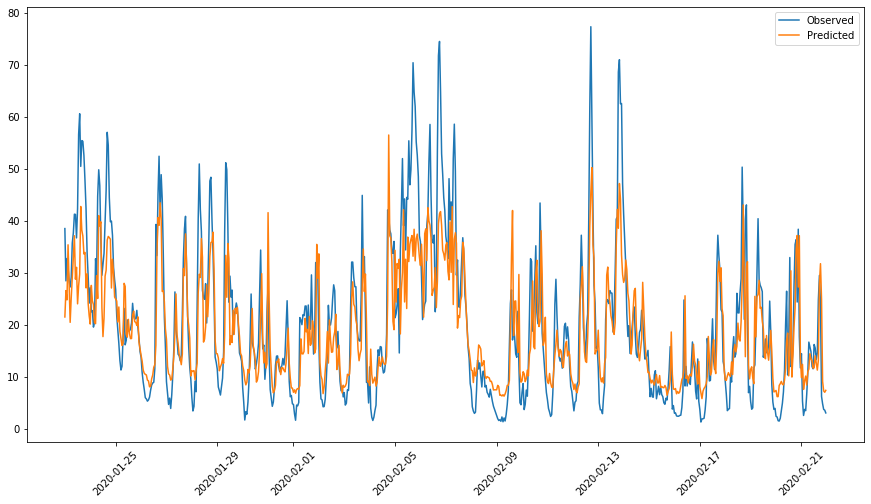

109, 3, RMSE:9.558059692382812, MAPE:0.5389289855957031, r2: 0.5876089248830487, corr:0.8650280952887327,(1.4793791085701429e-217) 
110, 4, RMSE:8.809276580810547, MAPE:0.36560532450675964, r2: 0.6496918742434075, corr:0.8375476349403373,(6.308830521713874e-191) 
sharston, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'Volume', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4'], layers:3  
111, 0, RMSE:7.986021995544434, MAPE:0.4094962179660797, r2: 0.7121072469597807, corr:0.8605912643052642,(7.082625848711072e-213) 
112, 1, RMSE:8.677165985107422, MAPE:0.43386033177375793, r2: 0.6601200357569059, corr:0.8762596469568351,(3.4454959770970246e-230) 
113, 2, RMSE:7.829664707183838, MAPE:0.5013346076011658, r2: 0.7232701389242333, corr:0.8781083954016795,(2.1870160718041424e-232) 


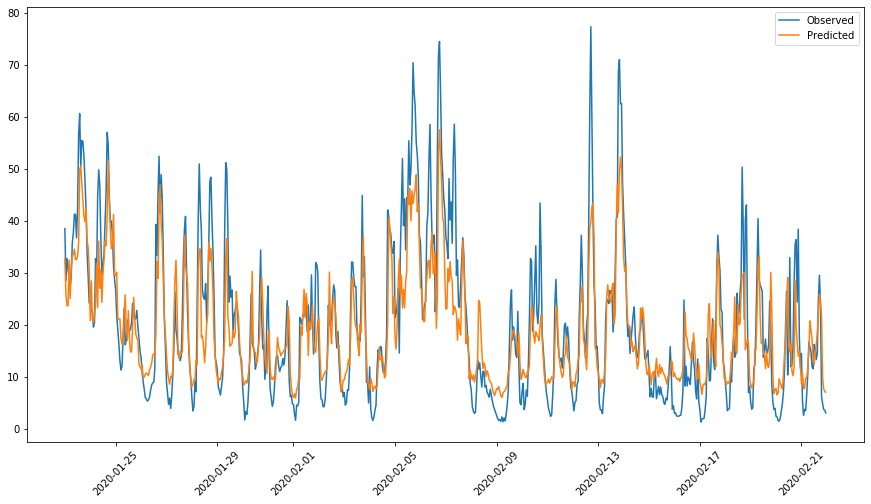

114, 3, RMSE:7.771274089813232, MAPE:0.5966404676437378, r2: 0.7273822168471443, corr:0.8731269431017252,(1.5183526608561337e-226) 
115, 4, RMSE:9.360233306884766, MAPE:0.4878760576248169, r2: 0.6045030952273716, corr:0.8498001030465484,(3.8723573008057708e-202) 
sharston, 2020-01-23, hb:24, ts:365, f:32, fs:2, n_seq:3, e:100, bs:128, dropout:0, c:24, vars:['NO2', 'ws', 'temp', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'Volume', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], layers:3  
116, 0, RMSE:8.656315803527832, MAPE:0.4859680235385895, r2: 0.6617514494920935, corr:0.856670825910022,(7.126592621071765e-209) 
117, 1, RMSE:8.794965744018555, MAPE:0.45605307817459106, r2: 0.6508291072972563, corr:0.8609318956718356,(3.137992455550795e-213) 
118, 2, RMSE:9.00700569152832, MAPE:0.5048667192459106, r2: 0.63378961268776, corr:0.8669812182071774,(1.1395650794743283e-219) 


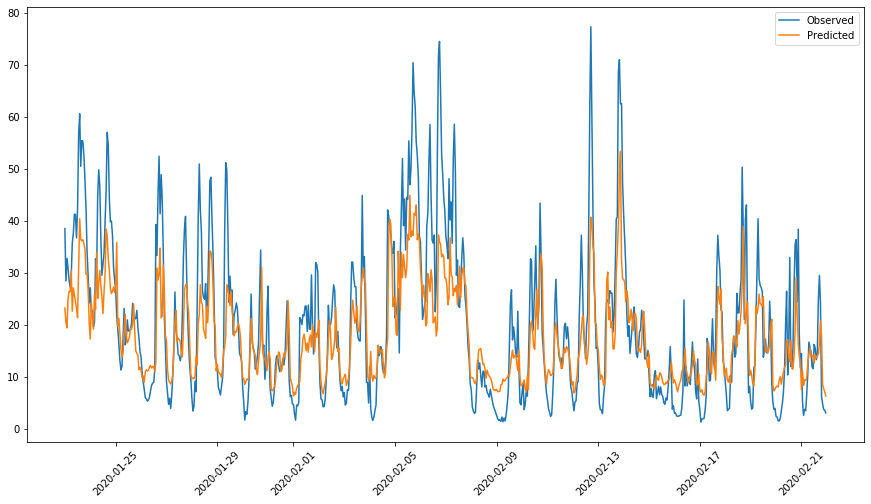

119, 3, RMSE:8.21894645690918, MAPE:0.48005953431129456, r2: 0.6950686371019246, corr:0.8495378604271202,(6.891756827800199e-202) 
120, 4, RMSE:7.767181396484375, MAPE:0.43134984374046326, r2: 0.7276692539675547, corr:0.8769497552786196,(5.261965255532918e-231) 


In [16]:
#-----------UPDATE PREDICTOR-----------
count = 0 
#---specify bounds of lag and prediction
for s in sites:

    dataset = pd.read_csv('./'+ s + '_combined.csv', header=0, index_col=0)
    
    dataset.index = pd.DatetimeIndex(dataset.index,freq='h')

    #get all dates
    all_dates = pd.to_datetime(dataset.index.to_numpy())


    #scale continuous variables --> ['temp', 'ws', 'wd', 'Volume']
    continuous_vars = ['temp', 'ws', 'wd', 'Volume']
    for i in continuous_vars:
        dataset[i] = scale(dataset,i,output_array=True)

    # scale NO2 keep mean and std for inverse scaling
    no2, mean, std, = scale(dataset,'NO2',output_array=False)
    dataset['NO2'] = no2
    for i in periods:
        for l in LAYERS:
            for f in FILTERS:
                for fs in FILTER_SIZE:
                    for n in N_SEQ:
                        for h in HOURS_BEFORE:
                            for b in BATCH_SIZE:
                                for c in CELLS:
                                    for d in DROPOUT:
                                        for e in EPOCHS:
                                            for t in TRAIN_SIZE:
                                                for v in VARIABLES:

                                                    print (f"{s}, {i}, hb:{h}, ts:{t}, f:{f}, fs:{fs}, n_seq:{n}, e:{e}, bs:{b}, dropout:{d}, c:{c}, vars:{v}, layers:{l}  ")

                                                    dataset_copy = dataset[v]

                                                    hours_before = h
                                                    hours_after = TIMESTEPS

                                                    days_before = 1
                                                    days_after = 1

                                                    # # specify the number of lag hours
                                                    n_hours = hours_before * days_before # lag hours for each feature (t-x)
                                                    n_features = len(v) # number of features 
                                                    n_hours_out = hours_after * days_after # lenghth of output forecast (<1 == <t+1)

                                                    date1 = i

                                                    #convert values
                                                    values = dataset_copy.values.astype('float32') 

                                                    # frame as supervised learning
                                                    reframed, names = series_to_supervised(values, n_hours, n_hours_out )


                                                    train , test,  dates , leftover = split_by_date(dataset_copy, reframed, date1, t)

            #                                         print(train.shape, test.shape, dates.shape)

                                                    n_seq = n
                                                    n_steps = int( n_hours / n_seq )

                                                    train_X, train_y, train_X_r = reshape(train, n_seq, n_steps, n_features)
                                                    test_X, test_y, test_X_r = reshape(test, n_seq, n_steps, n_features)

            #                                         print( train_X_r.shape, test_X_r.shape)

            #                                         print ( train_X_r[0] ) 

                                                    for rep in range (5):

                                                        model = CNN_LSTM_model(c,f,fs,d,l)

                                                        # fit network
                                                        history = model.fit(train_X_r, train_y, epochs=e, batch_size=b, validation_split = 0.2 , verbose=0, shuffle=False)

                                                        # get scaled prediction and observed values to calculate RMSE
                                                        predicted = model.predict(test_X_r)[::n_hours_out]
                                                        observed = test_y[::n_hours_out]



                                                        # rescale for plotting
                                                        predicted_rescaled = inverse_scale(predicted.flatten(), mean, std)[:dates.shape[0]]
                                                        observed_rescaled = inverse_scale(observed.flatten(), mean, std)[:dates.shape[0]]

                                                        r2 = r2_score(observed_rescaled,predicted_rescaled)
                                                        
                                                        MAPE = mean_absolute_percentage_error(observed_rescaled,predicted_rescaled)
                                                        
                                                        #calculate RMSE
                                                        RMSE = mean_squared_error(observed_rescaled,predicted_rescaled, squared = False)
                                                        
                                                        corr, p = stats.pearsonr(observed_rescaled,predicted_rescaled)


                                                    #     #calculate mean RMSE for each timestep 
                                                    #     lag_scores = np.array([mean_squared_error(observed_update[i],predicted_update[i], squared=False ) for i in range(observed_update.shape[0])])
                                                    #     lag_scores = np.mean(lag_scores.reshape(int(observed_update.shape[0]/TIMESTEPS),TIMESTEPS),axis=0)


                                                        results.append([s,i,h,t,f,fs,n,e, b, c, v,l,d,RMSE,MAPE,r2,corr,p] )
                                                        count +=1 
                                                        print(f'{count}, {rep}, RMSE:{RMSE}, MAPE:{MAPE}, r2: {r2}, corr:{corr},({p}) ')
                                                        #plot 
                                                        if rep == 2: 
                                                            plt.figure(figsize = (15,8))
                                                            plt.plot(dates[:24*plot_days],observed_rescaled[:24*plot_days],label='Observed')
                                                            plt.plot(dates[:24*plot_days],predicted_rescaled[:24*plot_days],label='Predicted')
                                                            plt.legend()
                                                            plt.xticks(rotation=45)
                                                            plt.show()

In [23]:
pd.DataFrame(results ,columns = ['site','date','hb','ts','fn','fs','nseq','epochs','bs','cs','vars','layers','dropout','RMSE','MAPE','r2','corr','p']).to_csv('./grid_seach_results/LSTMCNN_variable_comparison.csv')